# About
This notebook calculates proteome-wide IDR parameters

In [2]:
import numpy as np
import matplotlib
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list,fcluster
import matplotlib.patches as mpatches

import itertools
import metapredict as meta

from shephard.interfaces import si_proteins, si_protein_attributes,si_domains
from shephard import Proteome

from scipy.stats import ttest_ind

def cast_attributes(obj, include=[], exclude=[], cast_type=float):
    if len(include) > 0:
        for a in include:
            if a in obj.attributes:                
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
    if len(exclude) > 0:
        for a in obj.attributes:
            if a not in exclude:                
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
                

def peval(pval,n=1):
    if pval < 0.00001/n:
        return('****')
    elif pval < 0.0001/n:
        return('***')
    elif pval < 0.001/n:
        return('**')
    elif pval < 0.01/n:
        return('*')
    else:
        return('ns')


# lets you import from the code directory here
local_code_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'code'))

if local_code_path not in sys.path:
    sys.path.append(local_code_path)

from common_functions import annotate_with_quantiles
from afrc import AnalyticalFRC

from finches import CALVADOS_frontend
cf = CALVADOS_frontend()

/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [3]:
yp = Proteome()

# read in soluble proteins only
si_proteins.add_proteins_from_file(yp,'../data/experimental_data/shprd_proteome_soluble_only_v2.tsv')

# annotate with IDRs
si_domains.add_domain_attributes_from_file(yp,'../data/shprd_files/shprd_yeast_idrs.tsv')

# annotate with abundance
si_protein_attributes.add_protein_attributes_from_file(yp, '../data/shprd_files/shprd_yeast_copynumber_ghaemmaghami.tsv')

# annotate with interactome data
si_protein_attributes.add_protein_attributes_from_file(yp, '../data/shprd_files/shprd_interactome.tsv')

# annotate with domain data (CHAINSAW)
si_domains.add_domains_from_file(yp, '../data/shprd_files/shprd_chainsaw_domains_0.4.tsv')

# annotate with domain data (DODO) - called 'globular_shprd'
si_domains.add_domains_from_file(yp, '../data/shprd_files/shprd_dodo_domains_0.4.tsv')


# cast protein attributes 
for p in yp:
    cast_attributes(p, exclude=['partners', 'lip_color', 'non_ref_score', 'non_ref','refoldable', 'nonrefoldable','membrane_protein', 'subcellular_localization'])

# annotate every protein 
quantiles = annotate_with_quantiles(yp,proteins_with_domains=False)


for p in yp:
    # calculate fraction disordered
    num_disordered_res = np.sum([len(d) for d in p.domains if d.domain_type == 'IDR'])
    fraction_dis = num_disordered_res/len(p)
    p.add_attribute('fraction_disordered', fraction_dis, safe=False)
    p.add_attribute('num_disordered_res', num_disordered_res, safe=False)



# quantify
quant2IDR = {}
IDR_length_thresh = 40
for p in yp:

    # played around with this but set to 0 for final analysis
    # as ultimately had no effect
    if p.attribute('fraction_disordered') > 0.0:
        
        q = p.attribute('quantile')
        
        if q not in quant2IDR:
            quant2IDR[q] = []
    
        for d in p.domains:
            if d.domain_type =='IDR' and len(d) > IDR_length_thresh:
                quant2IDR[q].append(d.sequence)
                
            
print('\nNumber of proteins in each group after filteirng...')
[len(quant2IDR[k]) for k in quantiles]
vals = [len(quant2IDR[k]) for k in quantiles]

Sanity check number of proteins in each group
[404, 404, 403, 403, 403, 403, 403, 403]

Number of proteins in each group after filteirng...


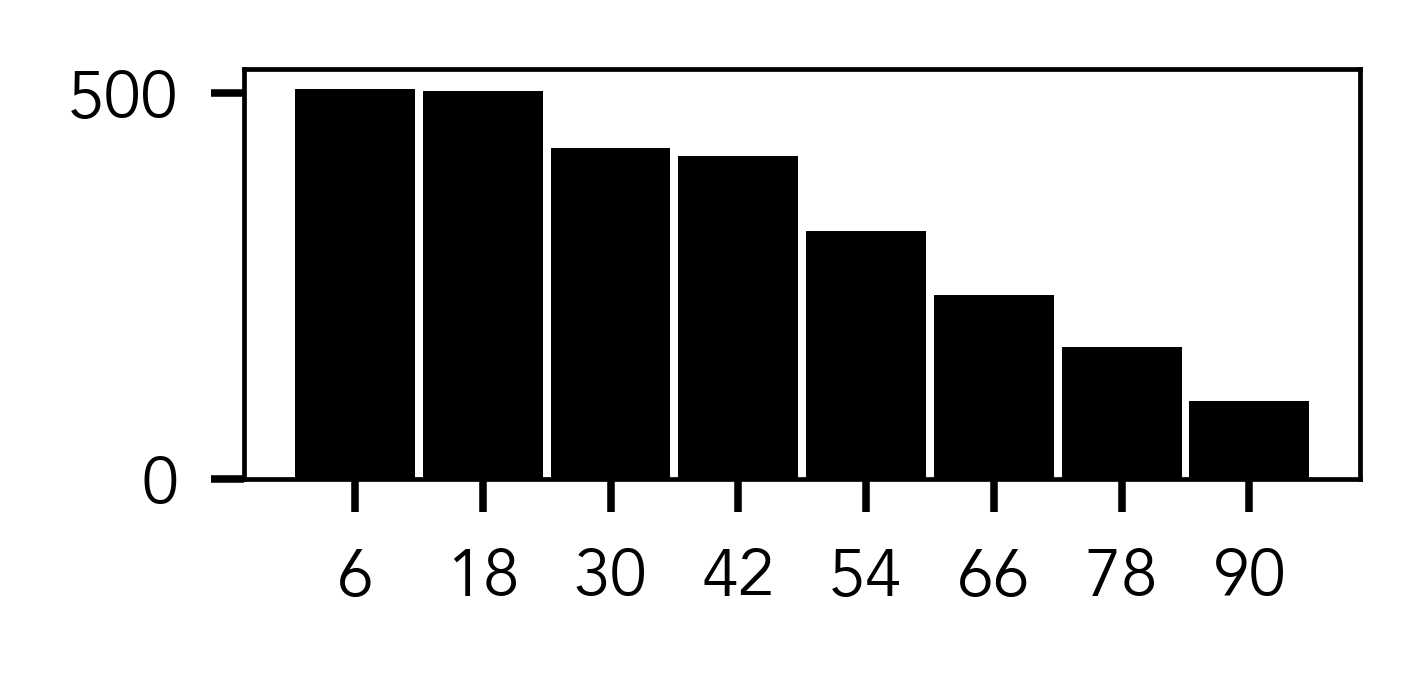

In [9]:
figure(None, (2.2, 1.1), dpi=340)
plt.bar(quantiles, vals, color='k', width=12.5*0.9)
plt.xticks(quantiles,quantiles, fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_count.pdf')


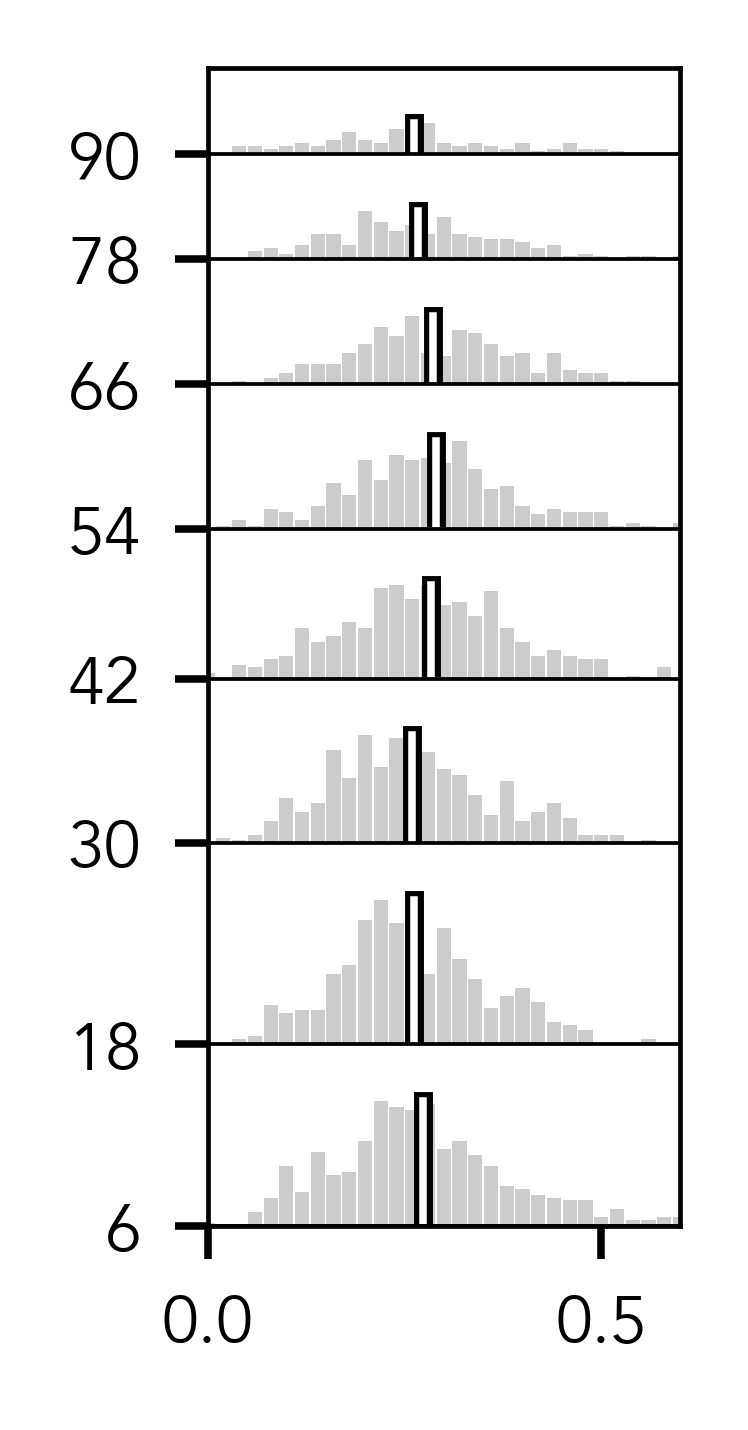

In [12]:
def calc_param(seq_list):
    return [Protein(s).FCR for s in seq_list]
all_scores =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}

bin_size = 0.02
bin_end = 1
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'k'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,0.6])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()

plt.tight_layout()
plt.savefig('outfigures_idrs/idr_fcr.pdf')


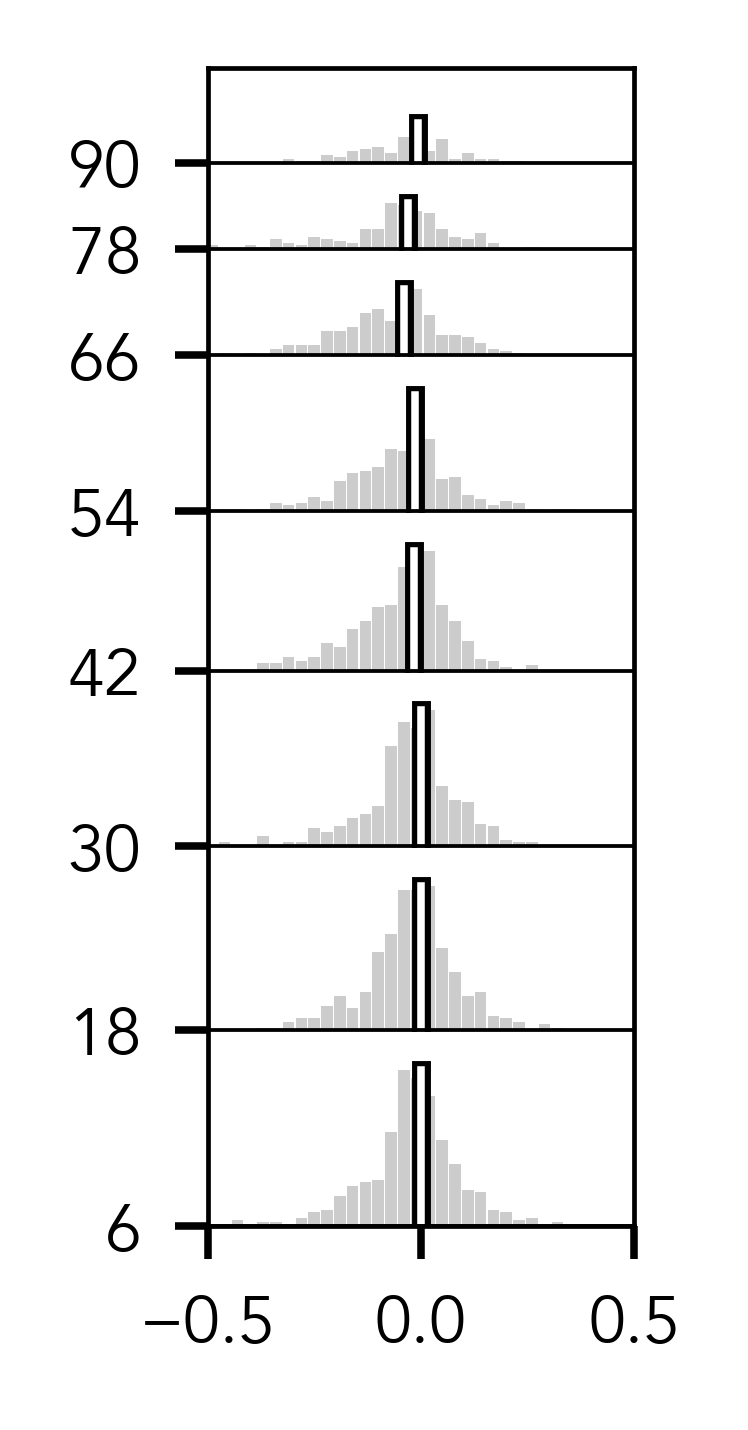

In [13]:
def calc_param(seq_list):
    return [Protein(s).NCPR for s in seq_list]
all_scores =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}

bin_size = 0.03
bin_end = 1
bins = np.arange(-1,bin_end+bin_size,bin_size)
lw = 2
color = 'k'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([-0.5,0.5])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_ncpr.pdf')


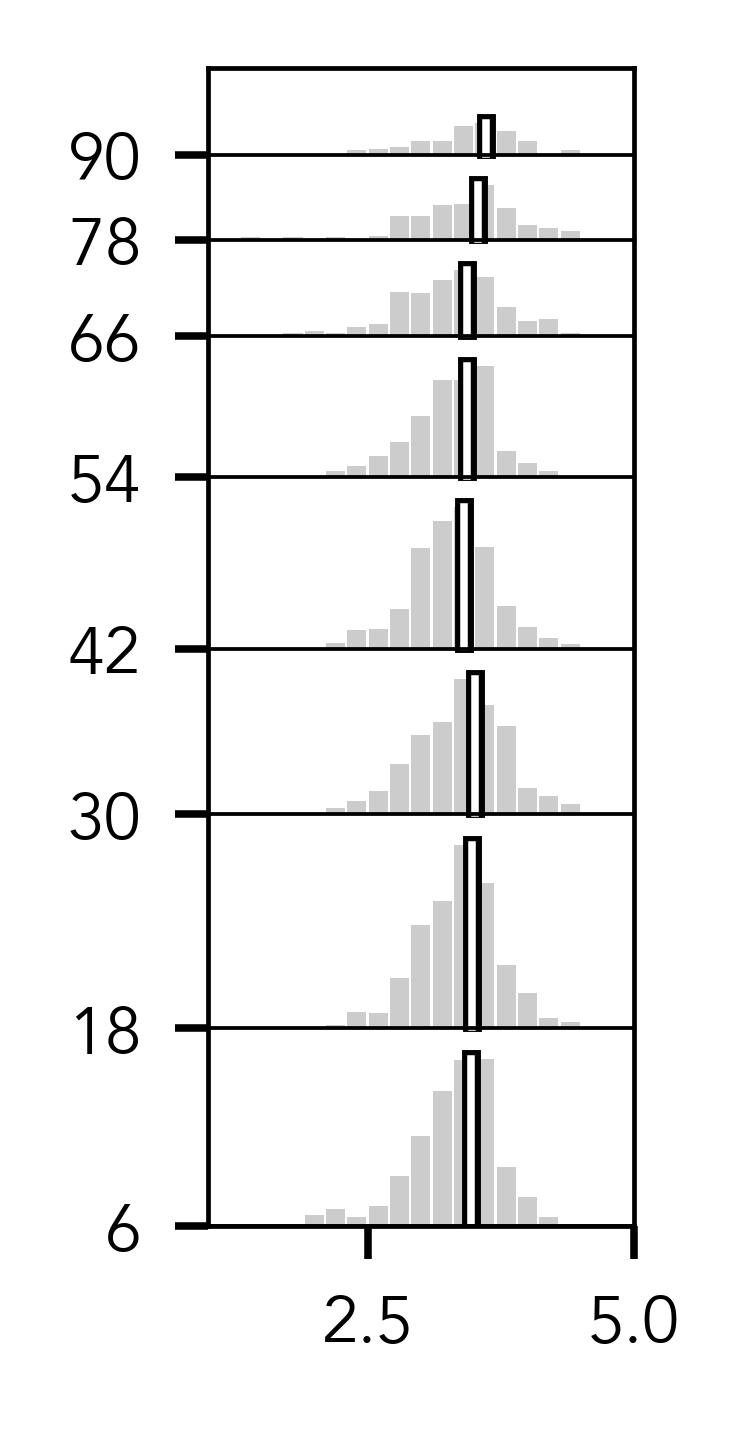

In [14]:
def calc_param(seq_list):
    return [Protein(s).hydrophobicity for s in seq_list]
all_scores =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}

bin_size = 0.2
bin_end = 10
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'k'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([1,5])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_hydrophobicity.pdf')


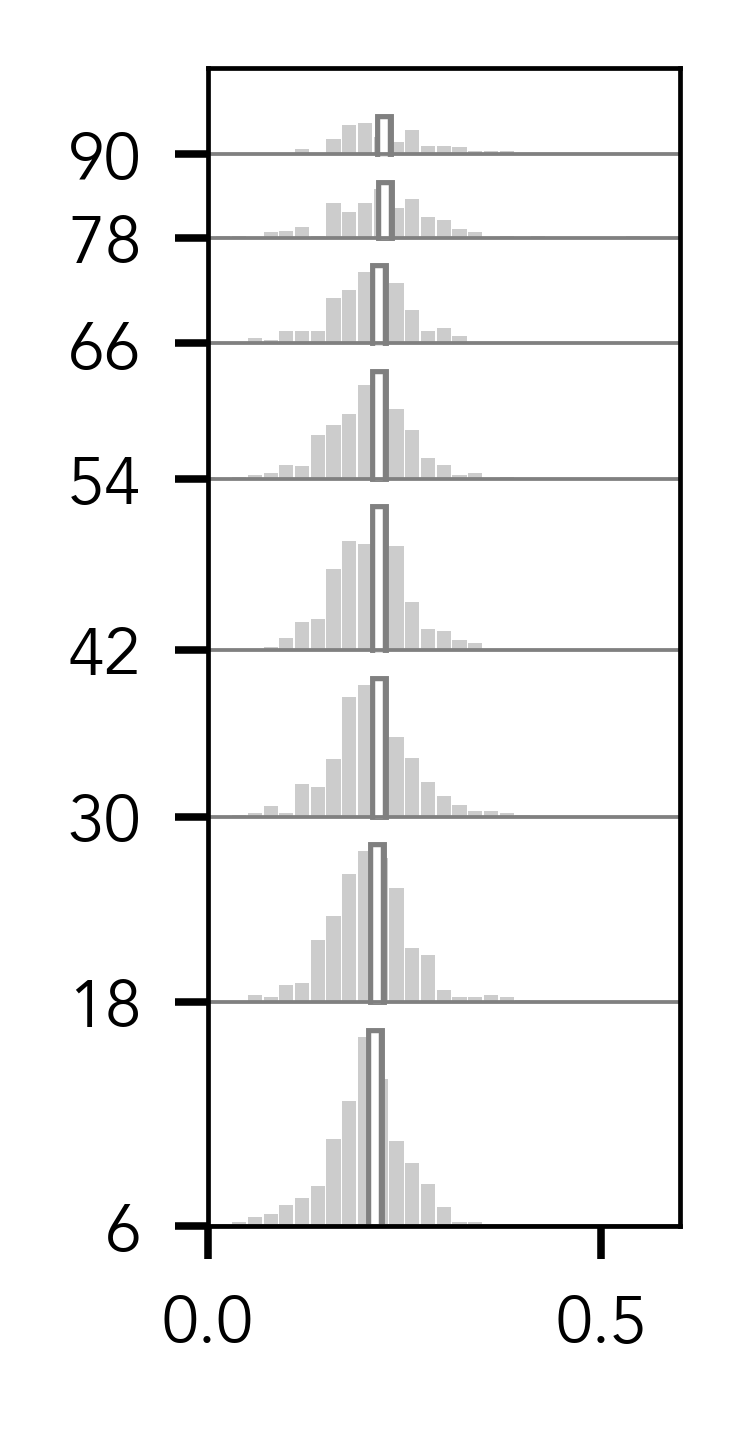

In [15]:
def calc_param(seq_list):
    return [Protein(s).fraction_aliphatic for s in seq_list]
all_scores =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}

bin_size = 0.02
bin_end = 1
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'grey'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.4, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,0.6])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_aliphatics.pdf')


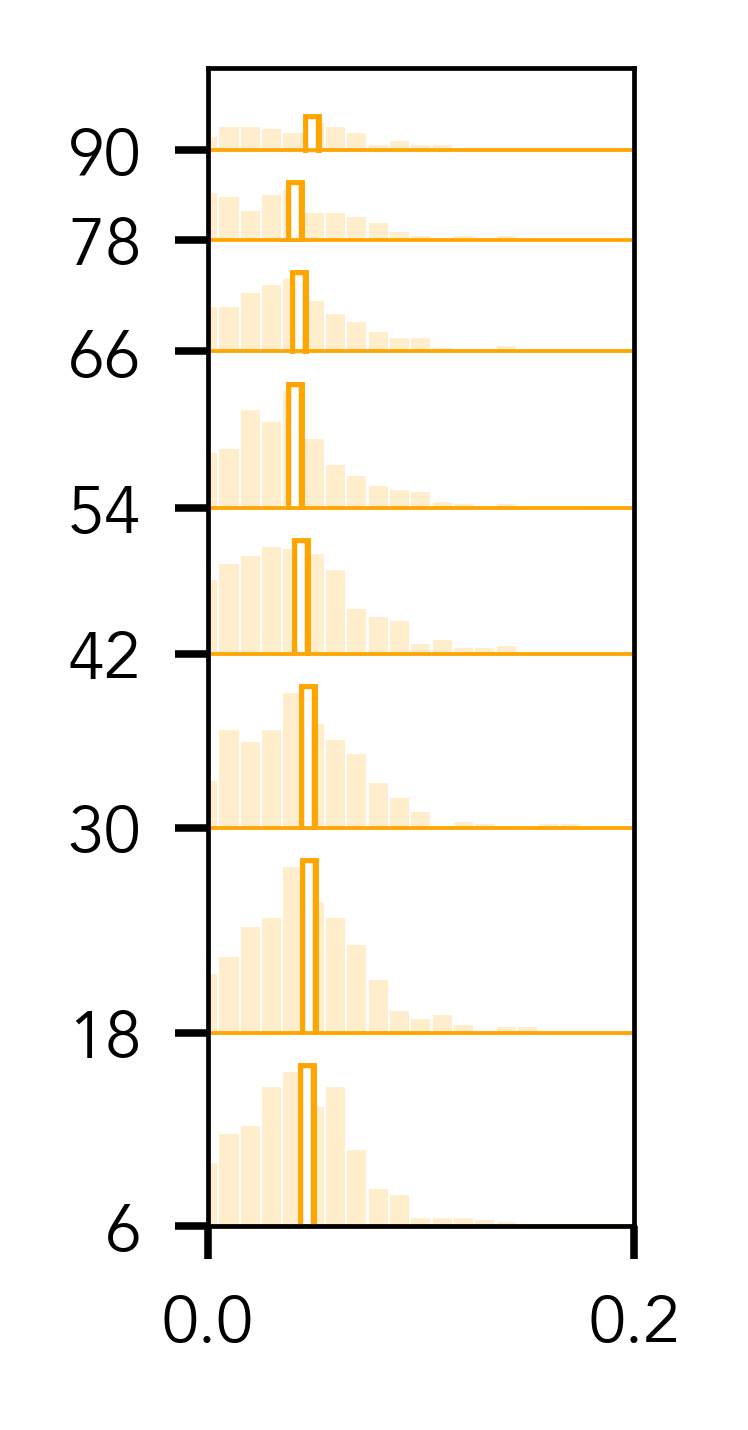

In [16]:
def calc_param(seq_list):
    return [Protein(s).fraction_aromatic for s in seq_list]
all_scores =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}

bin_size = 0.01
bin_end = 1
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'orange'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,0.2])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_aromatics.pdf')

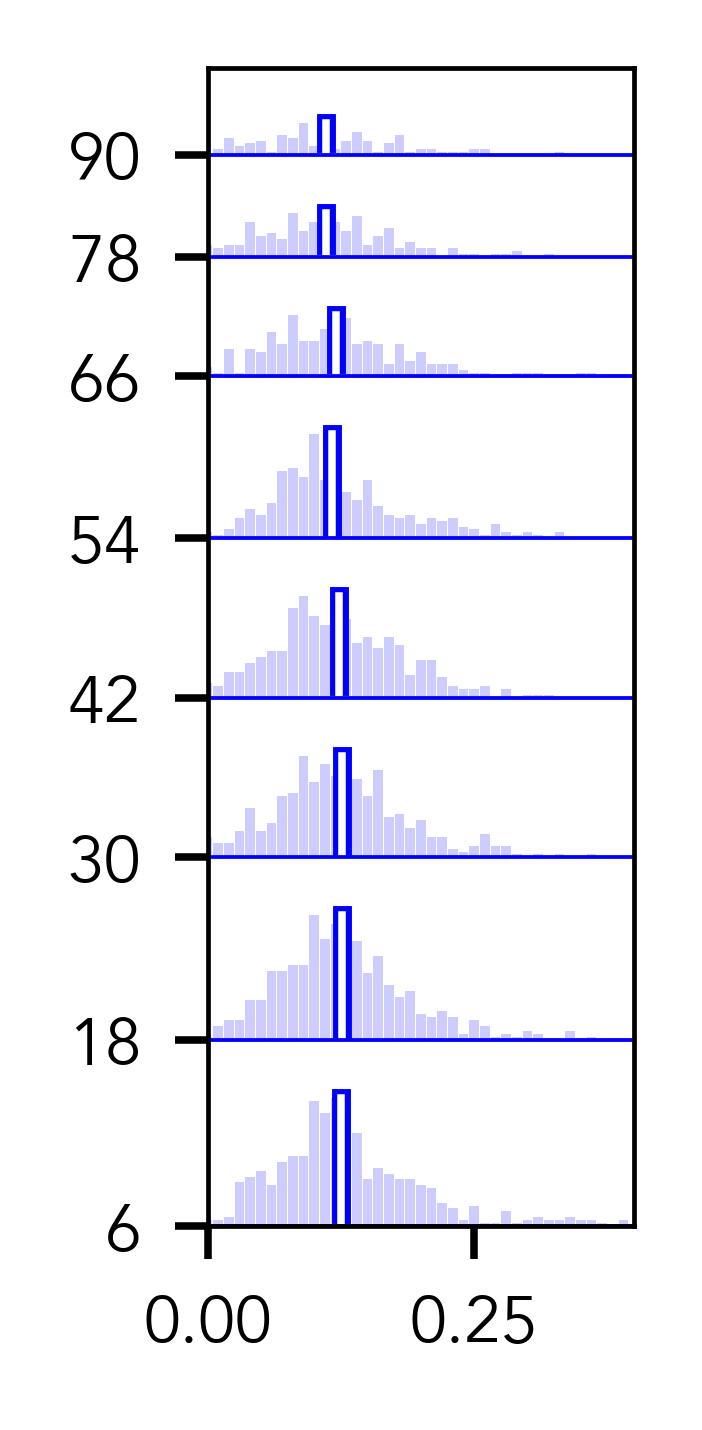

In [17]:
def calc_param(seq_list):
    return [Protein(s).fraction_positive for s in seq_list]
all_scores =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}

bin_size = 0.01
bin_end = 1
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'blue'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,0.4])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_positive.pdf')

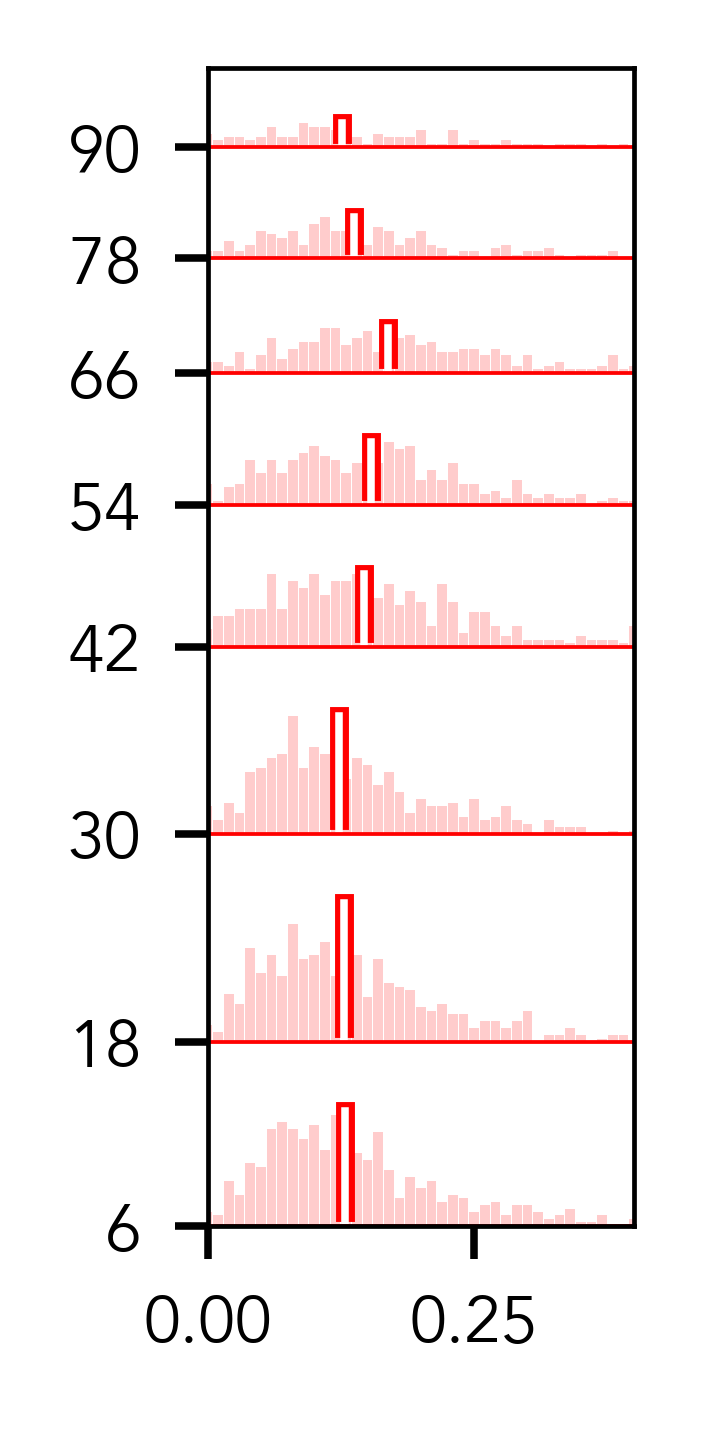

In [18]:
def calc_param(seq_list):
    return [Protein(s).fraction_negative for s in seq_list]
all_scores =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}

bin_size = 0.01
bin_end = 1
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'r'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,0.4])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_negative.pdf')

In [19]:
# takes ~20 seconds
def calc_param(seq_list):
    return [Protein(s).predictor.radius_of_gyration()/AnalyticalFRC(s).get_mean_radius_of_gyration() for s in seq_list]
all_scores_rg =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}


Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


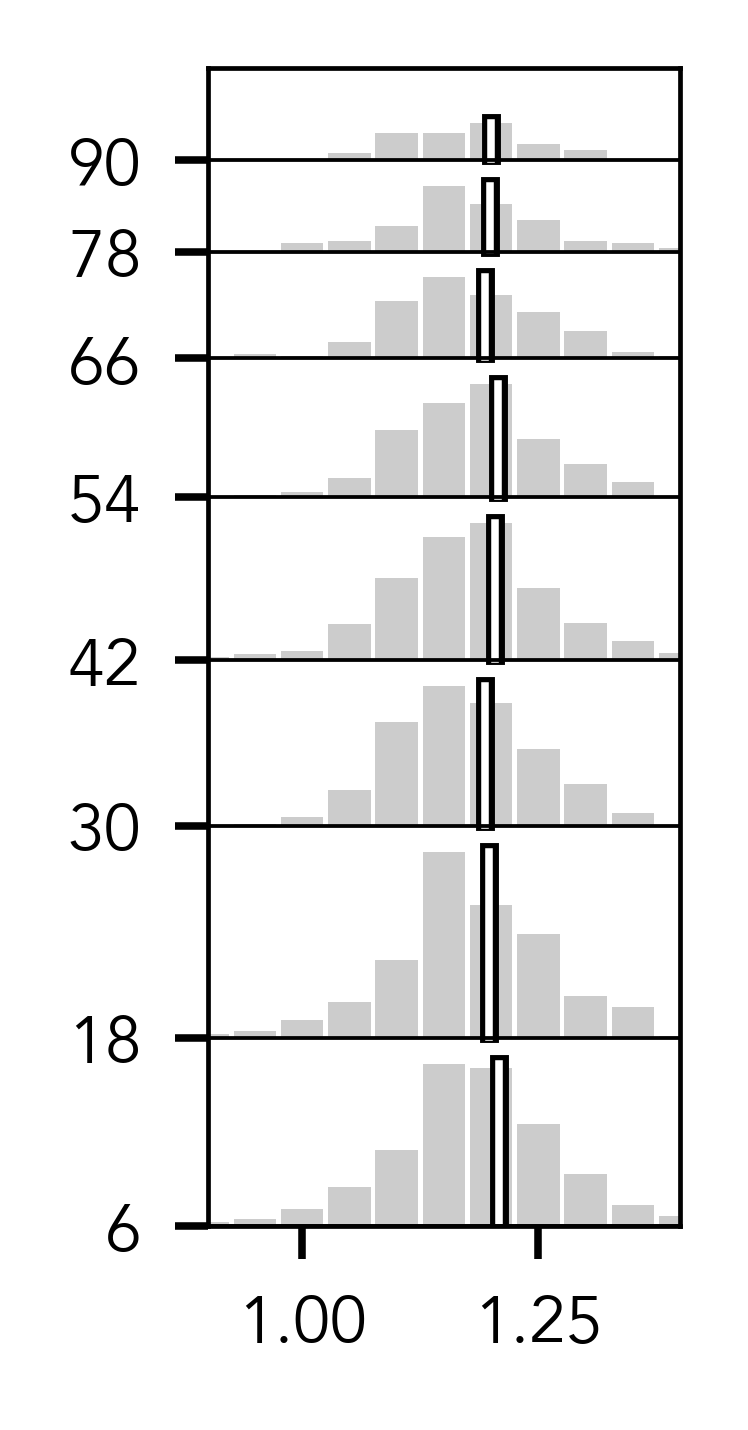

In [20]:

bin_size = 0.05
bin_end = 2
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'k'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores_rg[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0.9,1.4])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_rg.pdf')

In [21]:
# takes ~20 seconds
def calc_param(seq_list):
    return [Protein(s).predictor.end_to_end_distance()/AnalyticalFRC(s).get_mean_end_to_end_distance() for s in seq_list]
all_scores_re =  {q:calc_param(quant2IDR[q]) for q in quant2IDR}

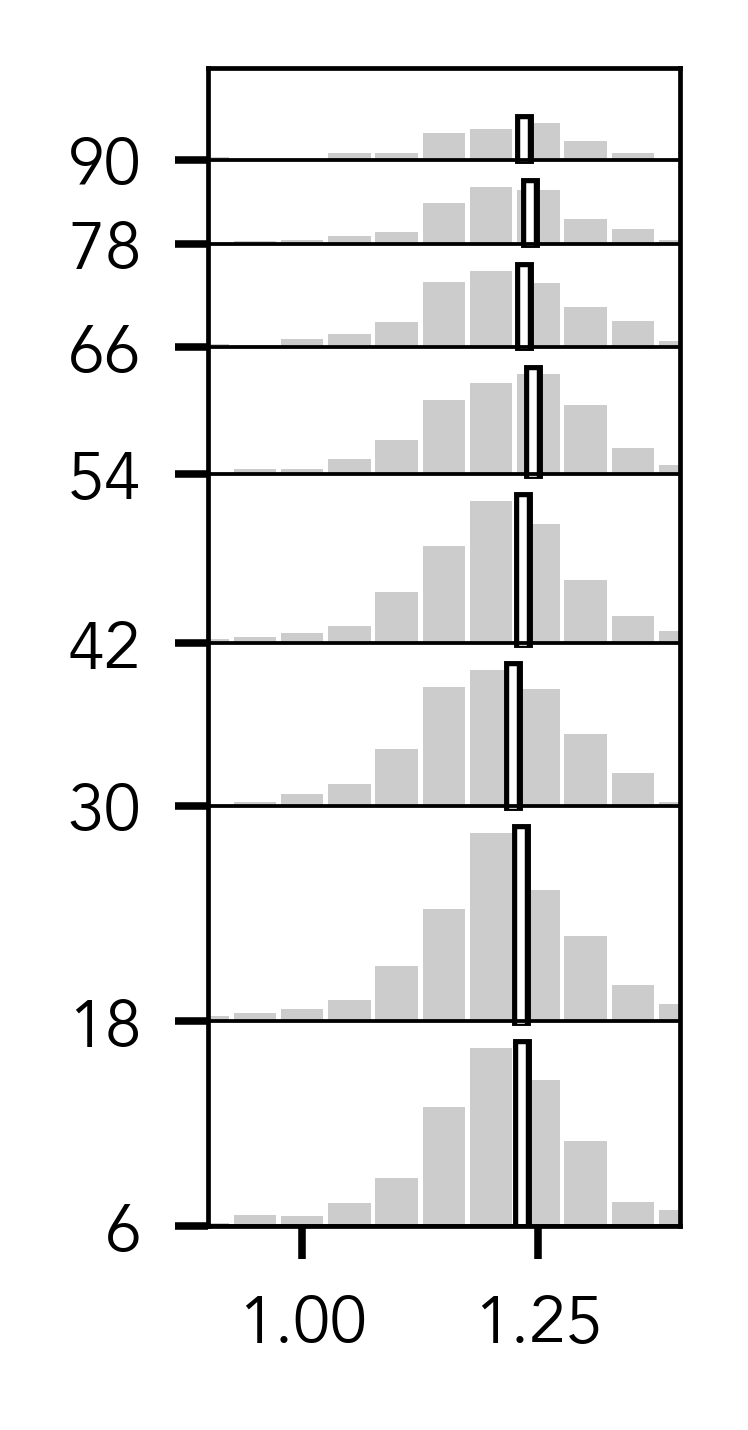

In [22]:

bin_size = 0.05
bin_end = 2
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'k'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = all_scores_re[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0.9,1.4])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures_idrs/idr_re.pdf')